# CFSv2 Comparison and assessment

12/17,11/2020

## Dataset notes
- There are met files for two time periods: 2011-2016 and 2018-2019
- cfsv2_2018-09-01_2019-10-01_tair.tif: Starts 2018-09-01
    - 6-hour time step
    - The first time step is 00:00
    - Per dataset metadata, there are 1580 time steps
    - `xarray.DataArray (band: 1580, y: 14, x: 11)`
    - Note how *regular* (rounded off) the spatial boundaries are, compared to what I get with my code and Ryan's original GEE lat-long bounding box

## TO-DOs
- Spatial alignment: Ensure the grid extent and cell resolution and boundary for the dataset I generate/download align with the sample dataset. This will take some iteration, but can do it on a single-time-step basis (processing a specified time interval will require a change to my code)
- Actual comparisons: whole individual time steps; time series at points (lat, lon coords)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import xarray as xr
from shapely.geometry import box
import geopandas as gpd

## Target bounding box

In [2]:
bbox_latlon = gpd.GeoSeries(box(-111.155208, 42.363116, -109.477849, 44.582480), crs='epsg:4326')  # crs='epsg:32612'
bbox = bbox_latlon.to_crs(epsg=32612)

## GEE tif

With `gdalinfo`:

```bash
mayorga@emilio-Lemur7:/home/mayorga/Downloads$ gdalinfo cfsv2_2018-09-01_2019-10-01_tair.tif
Driver: GTiff/GeoTIFF
Files: cfsv2_2018-09-01_2019-10-01_tair.tif
Size is 11, 14
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 12N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 12N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-111,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["unknown"],
        AREA["World - N hemisphere - 114°W to 108°W - by country"],
        BBOX[0,-114,84,-108]],
    ID["EPSG",32612]]
Data axis to CRS axis mapping: 1,2
Origin = (444000.000000000000000,4972800.000000000000000)
Pixel Size = (22200.000000000000000,-22200.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  444000.000, 4972800.000) (111d42'33.73"W, 44d54'23.12"N)
Lower Left  (  444000.000, 4662000.000) (111d40'38.39"W, 42d 6'29.14"N)
Upper Right (  688200.000, 4972800.000) (108d37' 1.04"W, 44d53' 1.52"N)
Lower Right (  688200.000, 4662000.000) (108d43'28.12"W, 42d 5'15.10"N)
Center      (  566100.000, 4817400.000) (110d10'56.25"W, 43d30'23.79"N)
Band 1 Block=256x256 Type=Float32, ColorInterp=Gray
Band 2 Block=256x256 Type=Float32, ColorInterp=Undefined
...
Band 1579 Block=256x256 Type=Float32, ColorInterp=Undefined
Band 1580 Block=256x256 Type=Float32, ColorInterp=Undefined
```

In [3]:
gee_tif_fname = "cfsv2_2018-09-01_2019-10-01_tair.tif"

In [4]:
airt_gee_da = xr.open_rasterio(gee_tif_fname)

TO-DO:
- Set crs information correctly (per CF) in order for a direct comparison with the TDS-derived dataset to be possible
- Note that what's returned is a data array, not a dataset

In [5]:
print(airt_gee_da)

<xarray.DataArray (band: 1580, y: 14, x: 11)>
[243320 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 ... 1574 1575 1576 1577 1578 1579 1580
  * y        (y) float64 4.962e+06 4.94e+06 4.917e+06 ... 4.695e+06 4.673e+06
  * x        (x) float64 4.551e+05 4.773e+05 4.995e+05 ... 6.549e+05 6.771e+05
Attributes:
    transform:      (22200.0, 0.0, 444000.0, 0.0, -22200.0, 4972800.0)
    crs:            +init=epsg:32612
    res:            (22200.0, 22200.0)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area


In [6]:
(airt_gee_da.x[1] - airt_gee_da.x[0]).values, (airt_gee_da.y[1] - airt_gee_da.y[0]).values

(array(22200.), array(-22200.))

In [7]:
(airt_gee_da.x[0].values, airt_gee_da.x[-1].values), (airt_gee_da.y[0].values, airt_gee_da.y[-1].values)

((array(455100.), array(677100.)), (array(4961700.), array(4673100.)))

Note that northing (y) coordinate values are sorted from high to low

In [8]:
timesteps_cnt = len(airt_gee_da.coords['band'])
timesteps_cnt

1580

In [9]:
datetime(2018, 9, 1, 0, 0) + timesteps_cnt * timedelta(hours=6)

datetime.datetime(2019, 10, 1, 0, 0)

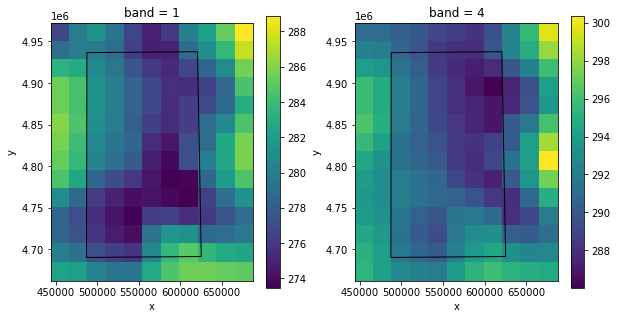

In [10]:
# Note that using subplots forced an aspect ratio of "equal", with cells now being square
# When plotting w/o subplots (just the data array plot), cells were not square
f, ax = plt.subplots(ncols=2, figsize=(10, 5))

# NOTE: band=0 is supposed to be 2018-09-01 00:00, but based on these plots, I'm not so sure ...
airt_gee_da.isel(band=0).plot(ax=ax[0])
bbox.plot(ax=ax[0], edgecolor='black', facecolor='none')

airt_gee_da.isel(band=3).plot(ax=ax[1])
bbox.plot(ax=ax[1], edgecolor='black', facecolor='none');

## NetCDF from TDS

- Generate new file spanning a time period covered by the GEE tif.
- The current, recent data are in `CFSv2_OperationalAnalysis_WY_2018-09.nc`
- **TO-DO:** When the reprojected resolution in TDS notebook is set to 20km (possibly coarser than the original resolution), some/many cells are set to the `_FillValue` but xarray didn't seem to properly apply the `_FillValue`. Need to investigate this

In [11]:
tds_ds_fname = 'CFSv2_OperationalAnalysis_WY_2018-09.nc'

In [12]:
tds_ds = xr.open_dataset(tds_ds_fname)
tds_ds

<xarray.Dataset>
Dimensions:                                                    (easting: 15, northing: 22, time: 12)
Coordinates:
  * easting                                                    (easting) float64 ...
  * northing                                                   (northing) float64 ...
  * time                                                       (time) datetime64[ns] ...
    crs                                                        int64 ...
Data variables:
    u-component_of_wind_height_above_ground                    (time, northing, easting) float32 ...
    Downward_Long-Wave_Radp_Flux_surface                       (time, northing, easting) float32 ...
    Temperature_height_above_ground                            (time, northing, easting) float32 ...
    Geopotential_height_surface                                (time, northing, easting) float32 ...
    Precipitation_rate_surface_6_Hour_Average                  (time, northing, easting) float32 ...
    Specific_humidity_height_above_ground                      (time, northing, easting) float32 ...
    Pressure_surface                                           (time, northing, easting) float32 ...
    v-component_of_wind_height_above_ground                    (time, northing, easting) float32 ...
    Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average  (time, northing, easting) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    grid_mapping:                                                            ...

In [13]:
airt_tds_da = tds_ds['Temperature_height_above_ground']

In [14]:
(airt_tds_da.easting[1] - airt_tds_da.easting[0]).values, (airt_tds_da.northing[1] - airt_tds_da.northing[0]).values

(array(22200.), array(-22200.))

In [15]:
(airt_tds_da.easting[0].values, airt_tds_da.easting[-1].values), (airt_tds_da.northing[0].values, airt_tds_da.northing[-1].values)

((array(411173.2188239), array(721973.2188239)),
 (array(5040670.05947151), array(4574470.05947151)))

- Note that northing coordinate values are sorted from high to low
- Investigate why the no-data areas are occurring on the edges; could it have something to do with the resampling scheme chosen?
- Another option to investigate is using a larger bbox buffer on the TDS data request, so that the reprojection resampling is not impacted by edge effects

In [16]:
airt_tds_da.coords['time'].values

array(['2018-08-31T06:00:00.000000000', '2018-08-31T12:00:00.000000000',
       '2018-08-31T18:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-09-01T06:00:00.000000000', '2018-09-01T12:00:00.000000000',
       '2018-09-01T18:00:00.000000000', '2018-09-02T00:00:00.000000000',
       '2018-09-02T06:00:00.000000000', '2018-09-02T12:00:00.000000000',
       '2018-09-02T18:00:00.000000000', '2018-09-03T00:00:00.000000000'],
      dtype='datetime64[ns]')

Plot two time steps

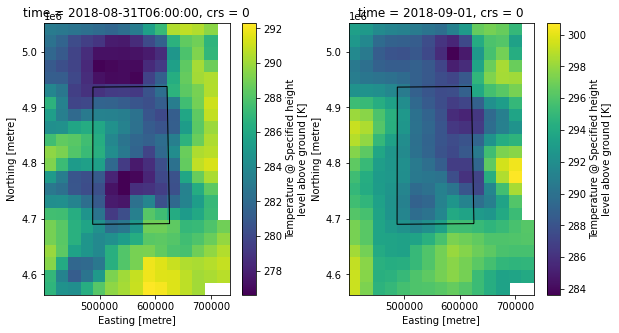

In [17]:
f, ax = plt.subplots(ncols=2, figsize=(10, 5))

airt_tds_da.isel(time=0).plot(ax=ax[0])
bbox.plot(ax=ax[0], edgecolor='black', facecolor='none')

airt_tds_da.isel(time=3).plot(ax=ax[1])
bbox.plot(ax=ax[1], edgecolor='black', facecolor='none');

In [18]:
airt_tds_da.isel(time=3).coords['time'].values

numpy.datetime64('2018-09-01T00:00:00.000000000')

## Compare GEE vs TDS

### Plot overlaying the histograms for the same time period, for the two datasets

But keep in mind that the spatial domains are different; the TDS domain is larger.

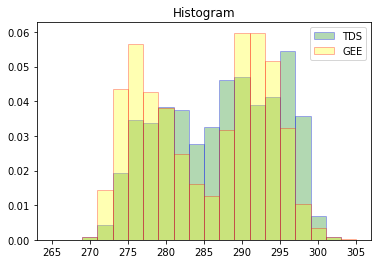

In [19]:
airt_tds_da.plot.hist(density=True, range=(265,305), bins=20, 
                      edgecolor='b', facecolor='green', alpha=0.3)
# Select a time (band) slice matching the TDS dataset time period
airt_gee_da.isel(band=slice(0,12)).plot.hist(density=True, range=(265,305), bins=20, 
                                             edgecolor='r', facecolor='yellow', alpha=0.3)
plt.legend(['TDS', 'GEE']);

### Time series plot averaging all cells at each time step

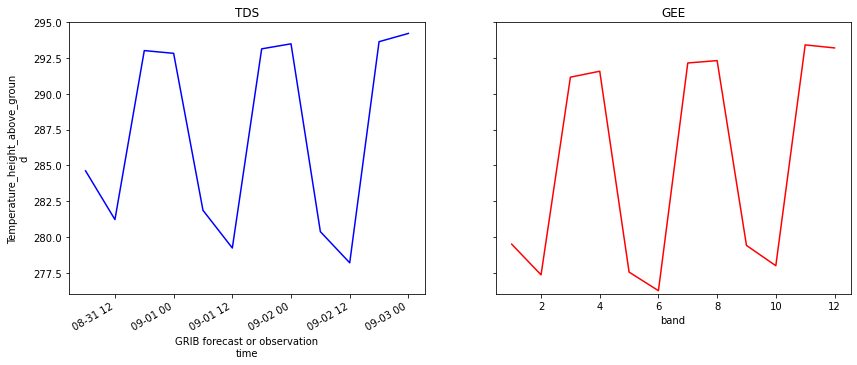

In [20]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(14, 5))
airt_tds_da.mean(['easting', 'northing']).plot(ax=ax[0], color='b')
ax[0].set_title('TDS')
airt_gee_da.mean(['x', 'y']).isel(band=slice(0,12)).plot(ax=ax[1], color='r')
ax[1].set_ylim(276, 295)
ax[1].set_title('GEE');

For `airt_gee_da`, the `band` dimension is just an incremental integer, not a datetime. So, we can't actually plot the two time series together yet

### Map plot of the two datasets at the same time period (best guess), using the same x-y ranges and value range

**NOTE:** The best match to TDS `isel(time=3)` (2018-09-01T00:00) seems to be `isel(band=3)`, NOT `isel(band=0)` as I expected

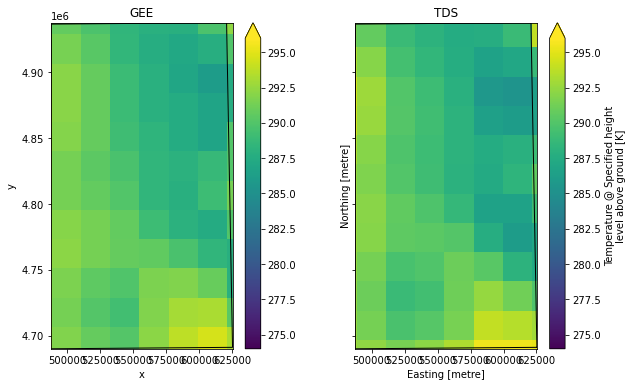

In [21]:
bounds = bbox.geometry.bounds

f, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 6))

airt_gee_da.isel(band=3).plot(ax=ax[0], vmin=274, vmax=296)
bbox.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_title('GEE')

airt_tds_da.isel(time=3).plot(ax=ax[1], vmin=274, vmax=296)
bbox.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].set_xlim([bounds.minx.min(), bounds.maxx.max()])
ax[1].set_ylim([bounds.miny.min(), bounds.maxy.max()])
ax[1].set_title('TDS');

## Examine timestamps, whether data match expected diurnal cycles

The Wyoming domain is in the Mountain time zone. MST UTC offset is -7 hours

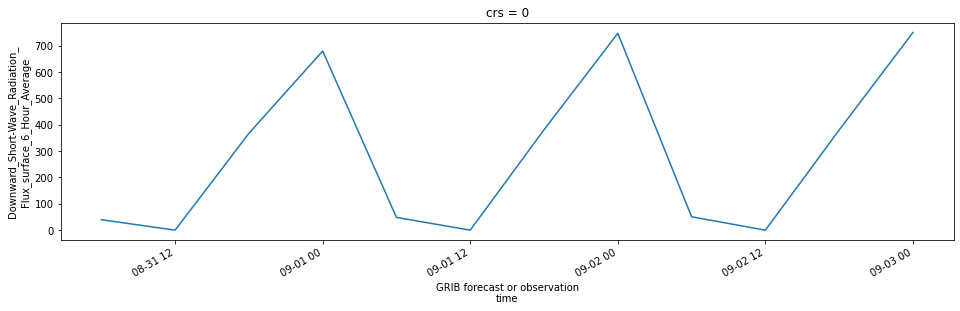

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 4))
tds_ds['Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average'].mean(['easting', 'northing']).plot(ax=ax);

In [22]:
#tds_ds.close()